In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qmcpy import Halton

# Smooth approximation of max
def softmax(a, b, tau=1e-4):
    return 0.5 * (a + b + np.sqrt((a - b)**2 + tau))

#Code for the L_2 star
def L2(L):
    n=len(L)
    a=0
    for i in range(n):
        a+=(1-L[i][0]**2)*(1-L[i][1]**2)
    a=a/(2*n)
    
    b=0
    for i in range(n):
        for j in range(n):
            b+=(1-max(L[i][0],L[j][0]))*(1-max(L[i][1],L[j][1]))
    b=b/(n**2)
    
    return(1/9-a+b)

def edge_penalty(P, epsilon=1e-9):
    """
    Penalize points near the boundary (x=0 or 1).
    P: array of shape (n, d)
    epsilon: small constant to avoid division by zero
    """
    return np.sum(1.0 / ((P + epsilon) * (1.0 - P + epsilon)))

def repulsion_penalty(P, epsilon=1e-9):
    n = len(P)
    total = 0.0
    for i in range(n):
        for j in range(i+1, n):
            dist_squared = np.sum((P[i] - P[j])**2)
            total += 1.0 / (dist_squared + epsilon)
    return total

# Smoothed L2 star discrepancy objective
def L2_smoothed(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b

# Smoothed L2 star discrepancy objective
def L2_updated(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b + 1e-7 * edge_penalty(P) + 1e-8 * repulsion_penalty(P)

# Project points to [0,1)
def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

def locdisc(x, y, P):
    no = 0
    nc = 0
    n = len(P)
    for i in range(n):
        if P[i][0] < x and P[i][1] < y:
            no += 1
        if P[i][0] <= x and P[i][1] <= y:
            nc += 1
    return max(x*y - no/n, nc/n - x*y)

def heatmap_from_array(P, ax=None):  # now accepts ax
    import numpy as np
    n = len(P)
    PX = P[:, 0]
    PY = P[:, 1]

    X = [0.001 * i for i in range(1001)]
    Y = [0.001 * i for i in range(1001)]
    Z = [[0 for _ in range(1001)] for _ in range(1001)]

    maxi = 0
    mxii = 0
    mxjj = 0
    for i in range(1001):
        for j in range(1001):
            Z[j][i] = locdisc(X[i], Y[j], P)
            if Z[j][i] > maxi:
                maxi = Z[j][i]
                mxii = i
                mxjj = j

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs, ax=ax, label="Local Discrepancy")
    ax.scatter(PX, PY, c='r', s=50, linewidth=1, alpha=0.7)
    ax.scatter(mxii/1000, mxjj/1000, c='black')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')

    return ax, maxi


def fibonacci_points(n):
    phi_inv = (np.sqrt(5) - 1) / 2  # ≈ 0.618...
    x = np.linspace(0, 1, n, endpoint=False)
    y = np.mod(np.arange(n) * phi_inv, 1.0)
    return np.column_stack((x, y))

In [2]:
def PGD_L2(start_points, max_iters=500, alpha=0.01, beta=0.5, tau=1e-4, tol=1e-6):
    n = len(start_points)
    P = start_points.copy()
    obj_values = []

    for it in range(max_iters):
        grad = np.zeros_like(P)
        eps = 1e-6
        f_val = L2_smoothed(P, tau)

        # Finite difference gradient
        for i in range(n):
            for j in range(2):
                P_perturbed = P.copy()
                P_perturbed[i, j] += eps
                f_perturbed = L2_smoothed(P_perturbed, tau)
                grad[i, j] = (f_perturbed - f_val) / eps

        # Backtracking line search
        t = 1.0
        while True:
            new_P = project_to_unit_cube(P - t * grad)
            if L2_smoothed(new_P, tau) <= f_val - alpha * t * np.sum(grad**2):
                break
            t *= beta
            if t < 1e-8:
                break

        P_new = new_P
        obj_new = L2(P_new)
        obj_values.append(obj_new)

        if np.linalg.norm(P_new - P) < tol:
            break
        P = P_new

    return P, obj_values

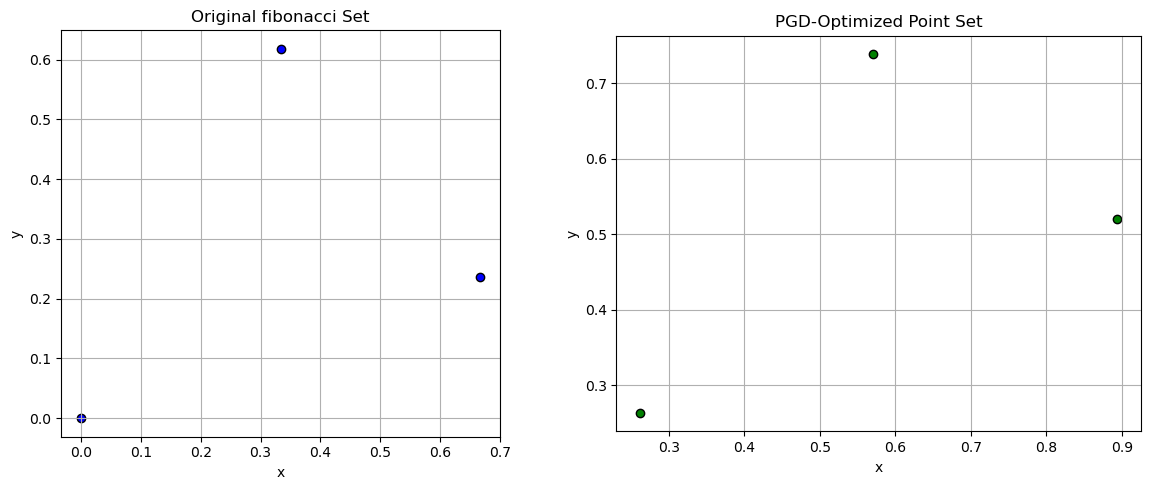

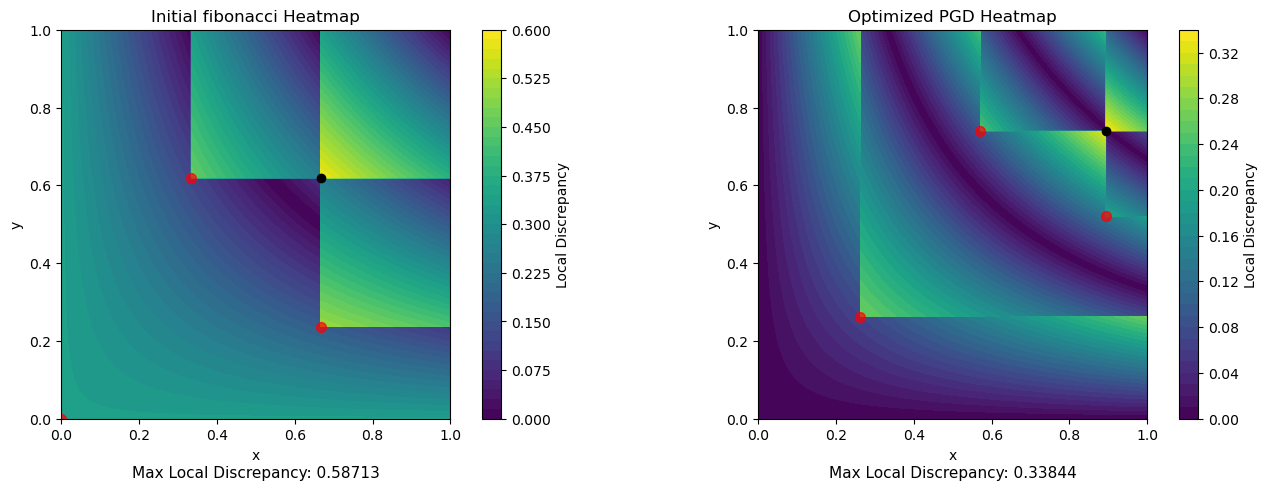

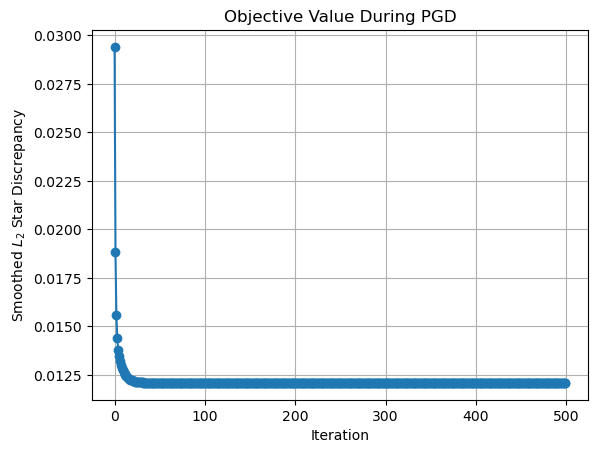

Initial L2 star discrepancy: 0.07461883064829616
Final discrepancy value: 0.012091629264887535
Optimized Points:
 [[0.26234175 0.26233157]
 [0.57120334 0.73905749]
 [0.89367431 0.51984801]]


In [3]:
# === Generate Halton points ===
init_points = fibonacci_points(3)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

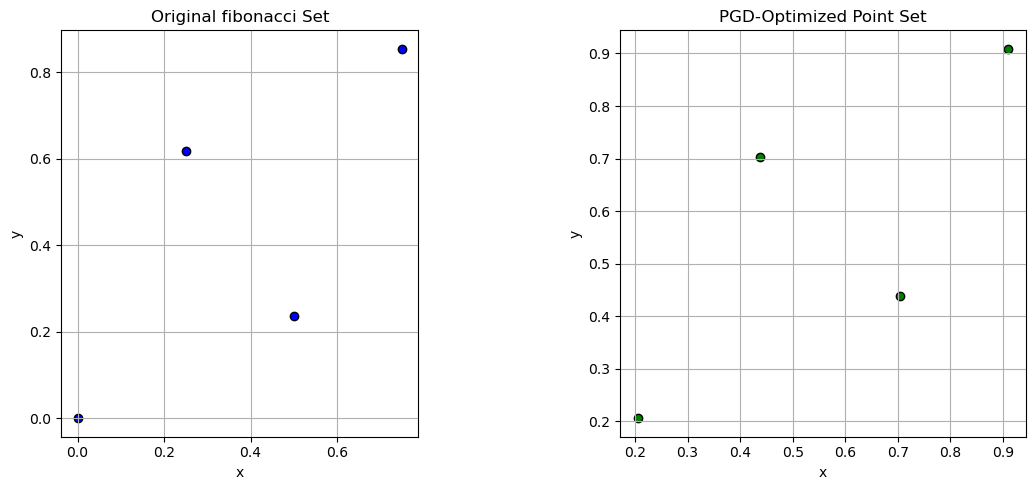

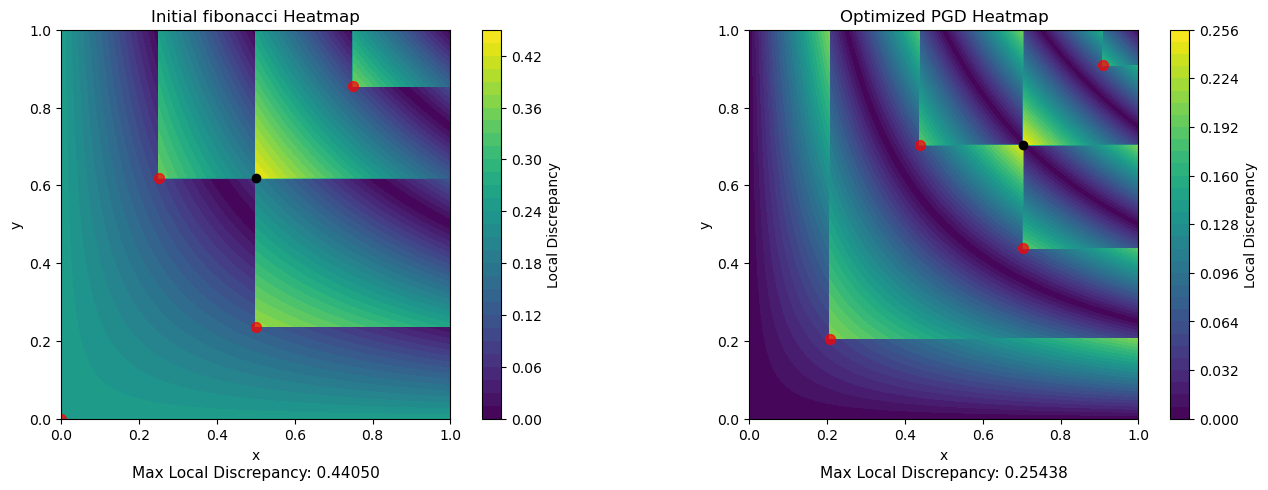

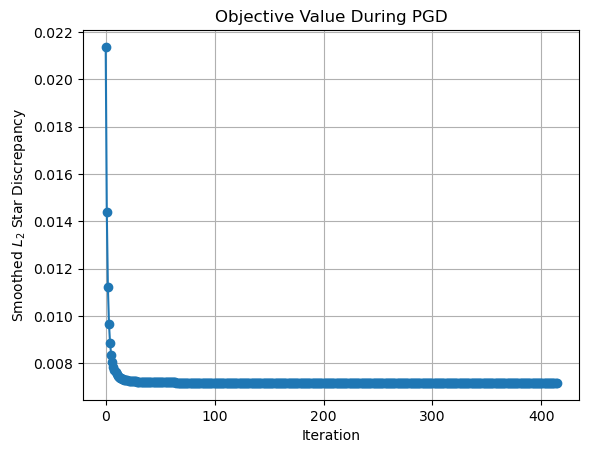

Initial L2 star discrepancy: 0.03802932568167661
Final discrepancy value: 0.007177199529087019
Optimized Points:
 [[0.20608108 0.20608108]
 [0.43775497 0.70337753]
 [0.70337751 0.43775498]
 [0.9087788  0.90885186]]


In [7]:
# === Generate Halton points ===
init_points = fibonacci_points(4)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

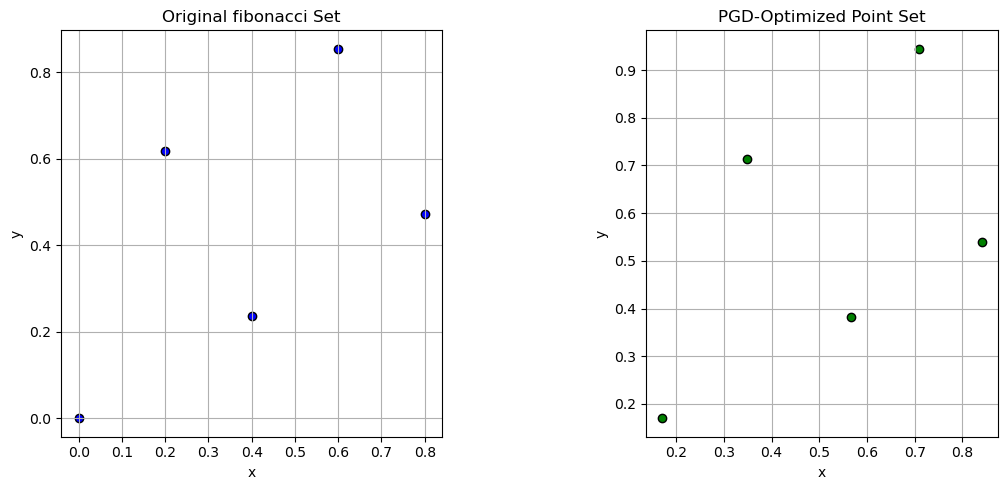

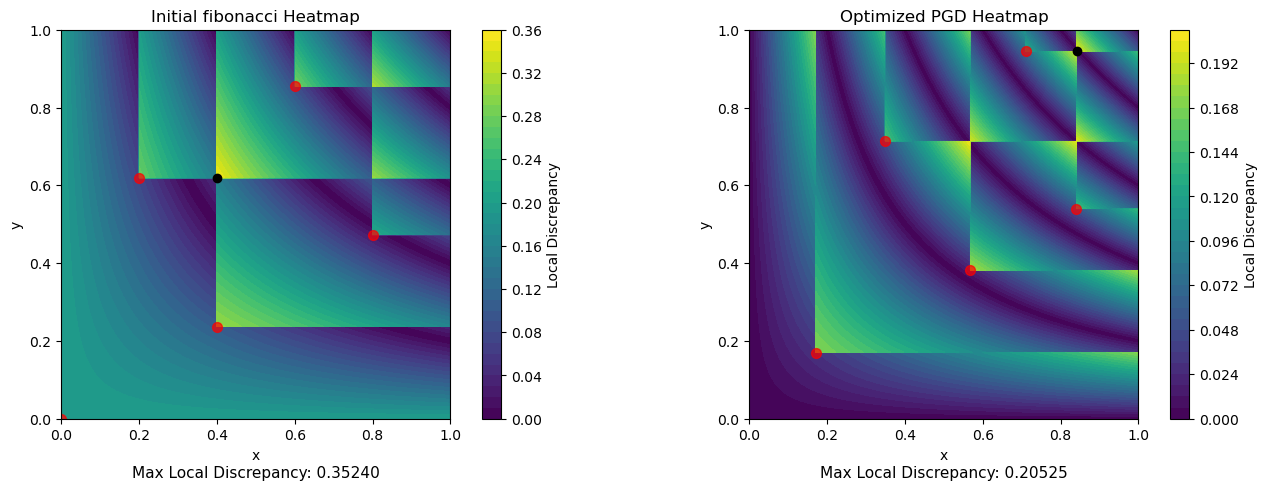

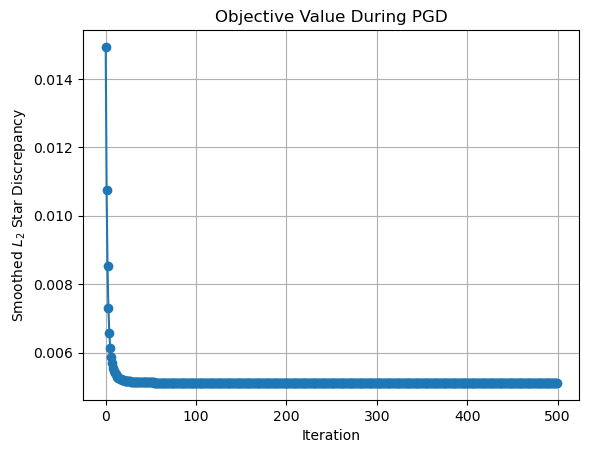

Initial L2 star discrepancy: 0.023080401051503163
Final discrepancy value: 0.0051155111237018575
Optimized Points:
 [[0.1700495  0.17004201]
 [0.34813601 0.71308819]
 [0.56737757 0.38131744]
 [0.70981135 0.94459629]
 [0.84083988 0.53962441]]


In [9]:
# === Generate Halton points ===
init_points = fibonacci_points(5)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

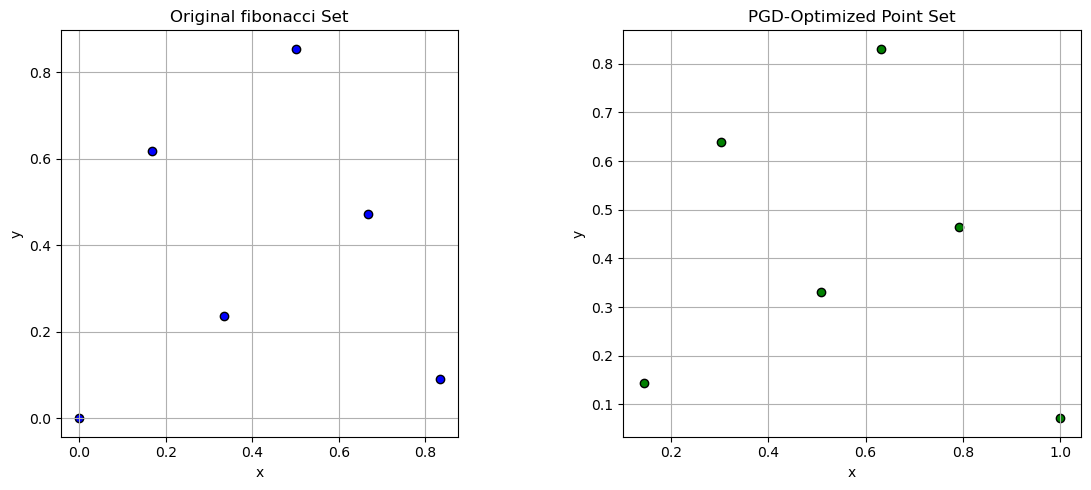

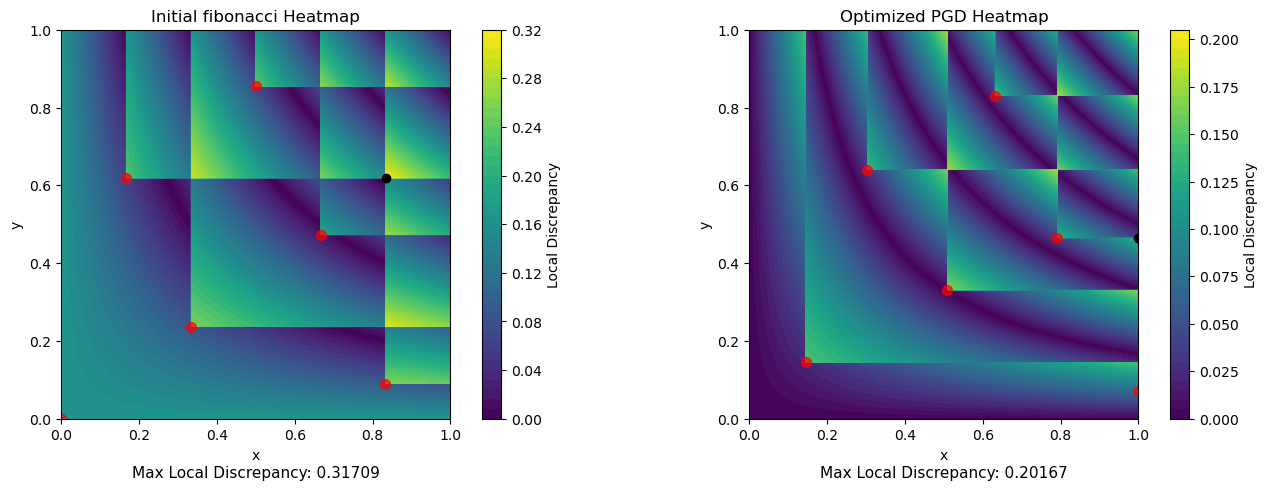

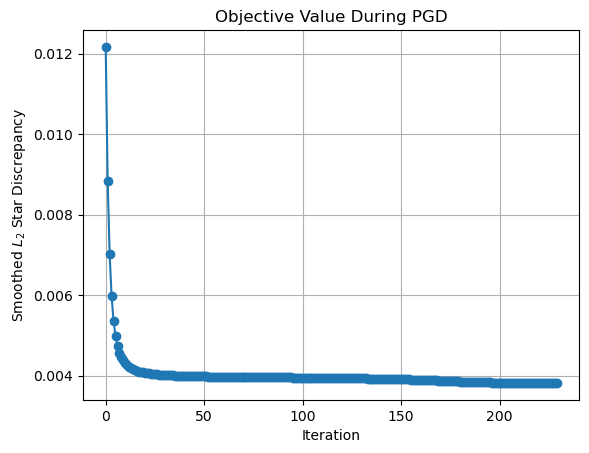

Initial L2 star discrepancy: 0.018394361942121212
Final discrepancy value: 0.0038227368065443246
Optimized Points:
 [[0.14491538 0.14487976]
 [0.30303915 0.64018168]
 [0.50911148 0.33034356]
 [0.63185344 0.83059573]
 [0.79129102 0.46435812]
 [0.99999999 0.0717386 ]]


In [13]:
# === Generate Halton points ===
init_points = fibonacci_points(6)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

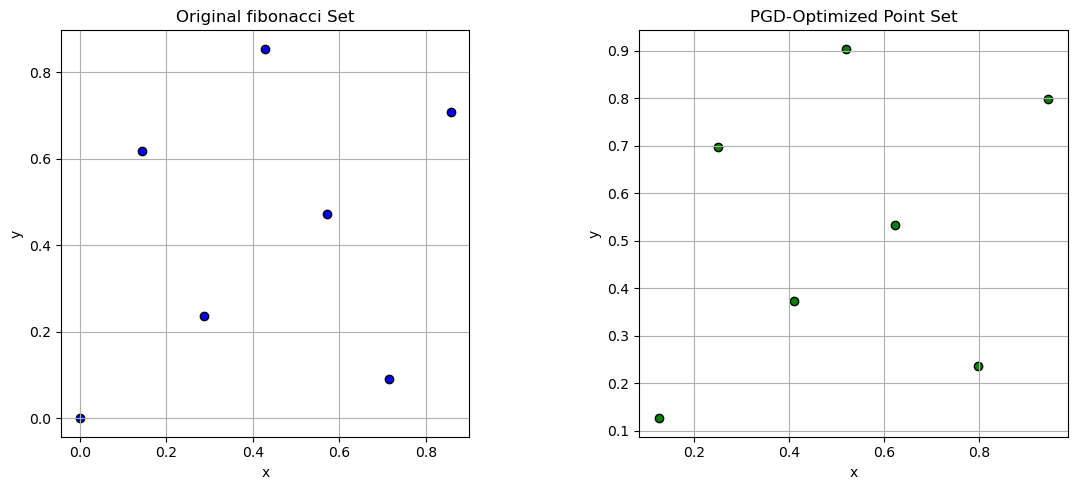

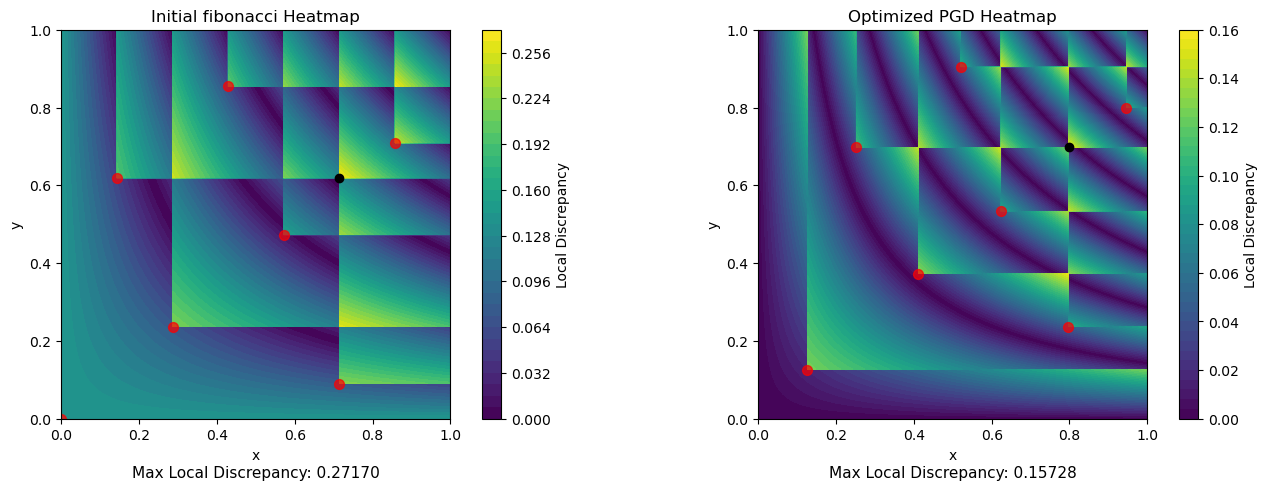

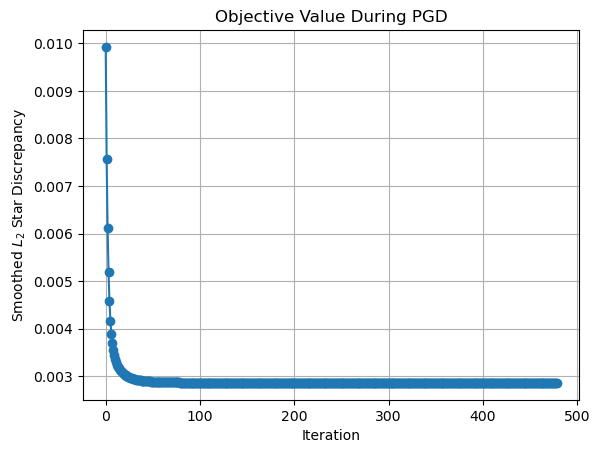

Initial L2 star discrepancy: 0.013764395193518852
Final discrepancy value: 0.002860776878335733
Optimized Points:
 [[0.12633595 0.12633793]
 [0.25100196 0.69759823]
 [0.41172802 0.3724362 ]
 [0.52098515 0.90409351]
 [0.62363743 0.53339958]
 [0.79724037 0.23643626]
 [0.9464166  0.79937656]]


In [15]:
# === Generate Halton points ===
init_points = fibonacci_points(7)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

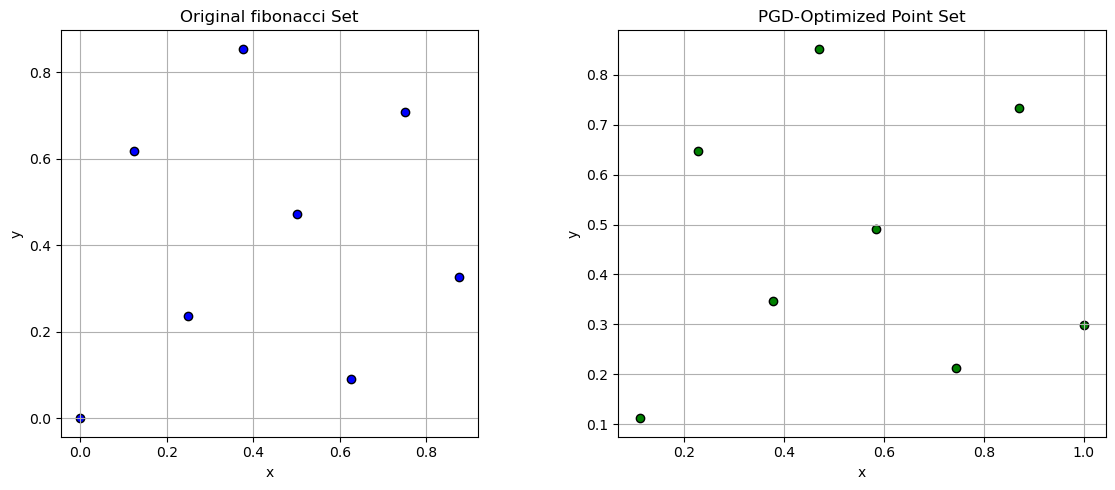

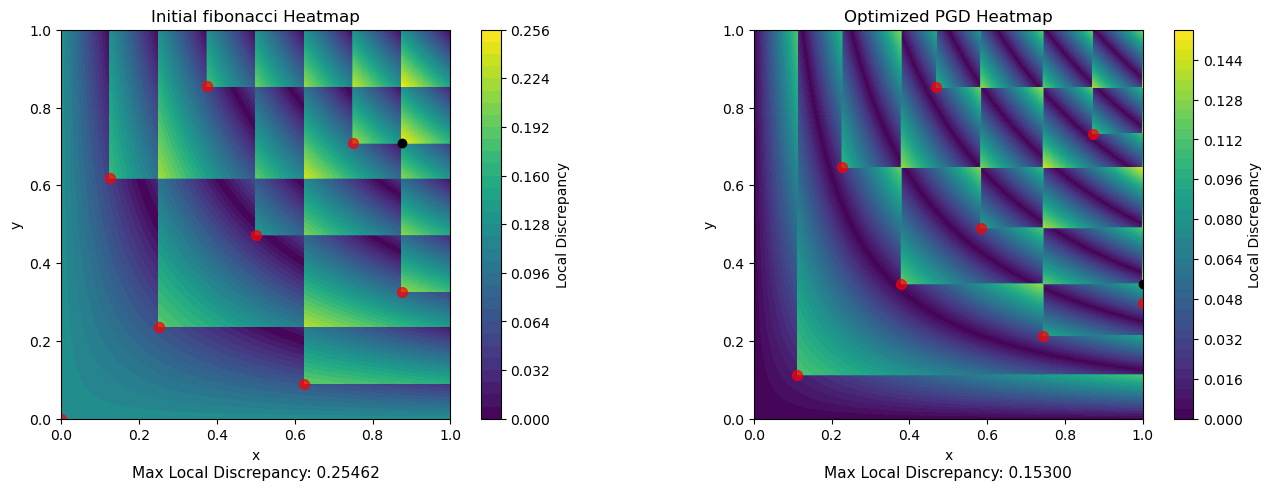

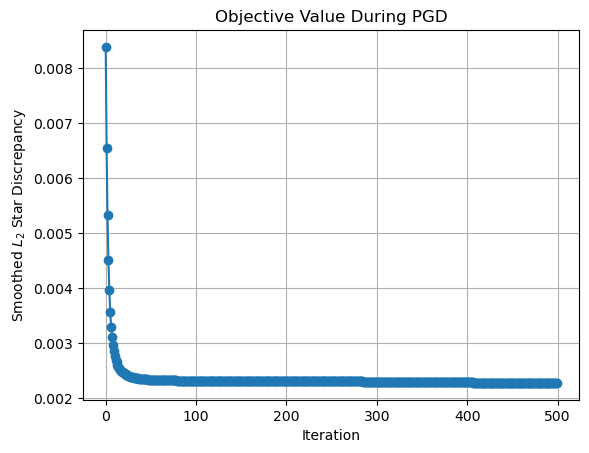

Initial L2 star discrepancy: 0.011221203856264517
Final discrepancy value: 0.0022769656193239868
Optimized Points:
 [[0.11204313 0.11204345]
 [0.22659142 0.64628474]
 [0.37827822 0.34612955]
 [0.4691945  0.85189902]
 [0.58317548 0.49086612]
 [0.7439914  0.21365221]
 [0.87065645 0.73316218]
 [0.99999999 0.29861772]]


In [17]:
# === Generate Halton points ===
init_points = fibonacci_points(8)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

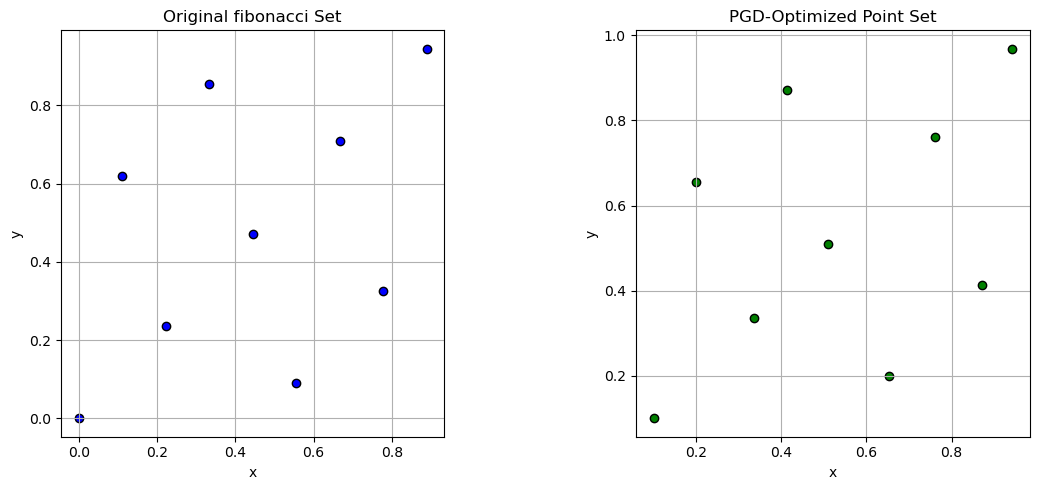

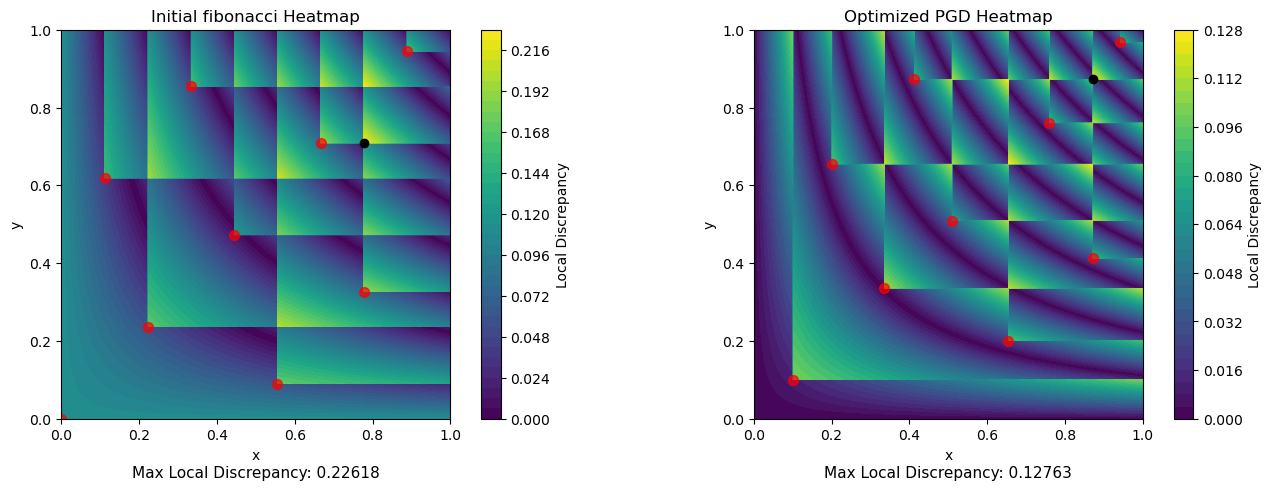

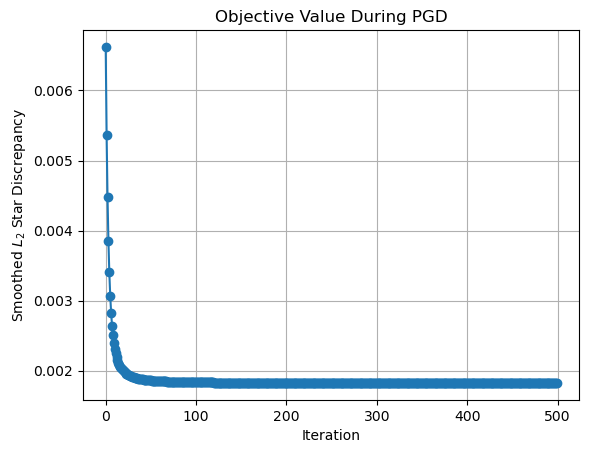

Initial L2 star discrepancy: 0.008416004857243337
Final discrepancy value: 0.0018266041565522945
Optimized Points:
 [[0.1006931  0.10069326]
 [0.20046652 0.65413884]
 [0.33561048 0.33565444]
 [0.41275116 0.87212661]
 [0.50929409 0.5094184 ]
 [0.65400589 0.20048703]
 [0.75988555 0.76006889]
 [0.87192501 0.41283836]
 [0.94214391 0.96780641]]


In [19]:
# === Generate Halton points ===
init_points = fibonacci_points(9)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

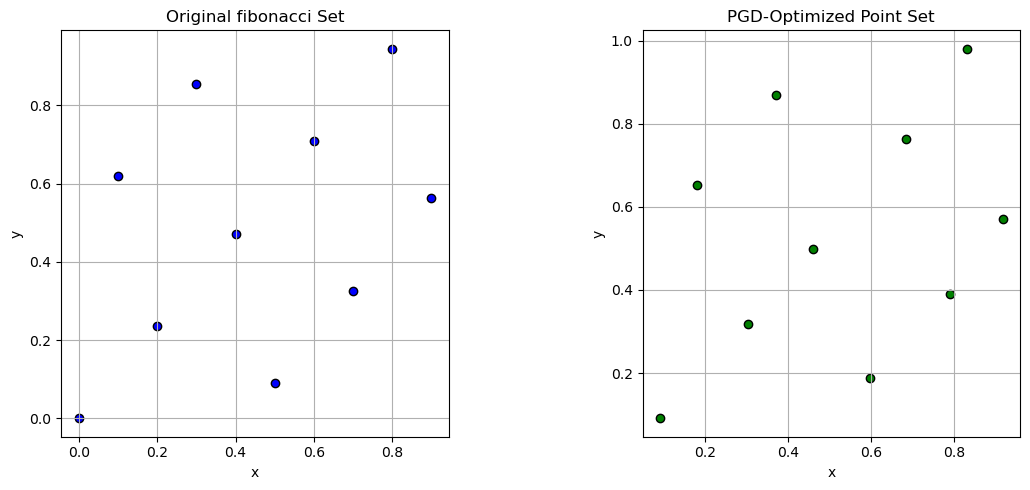

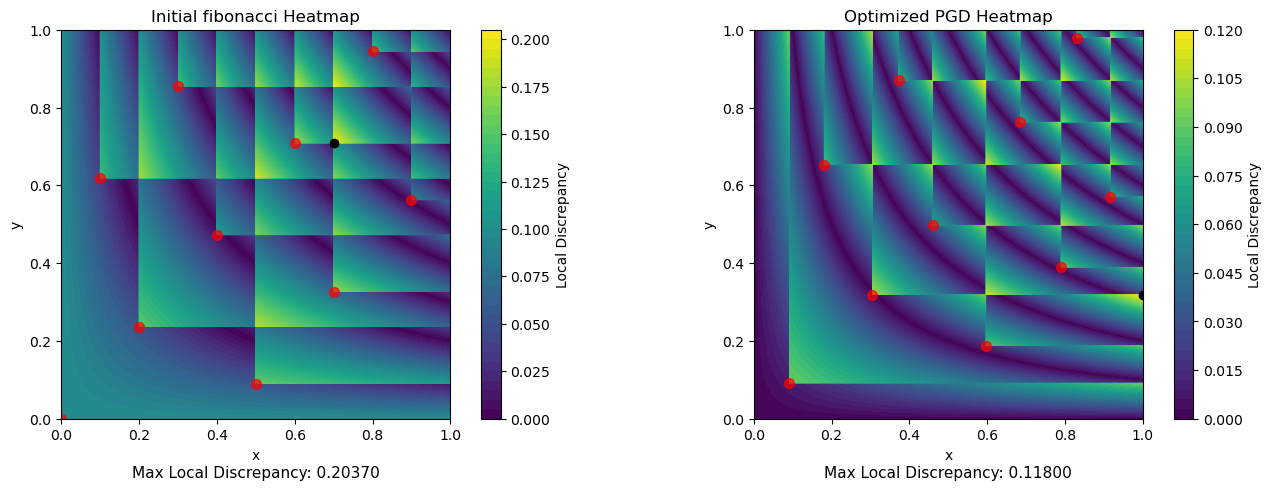

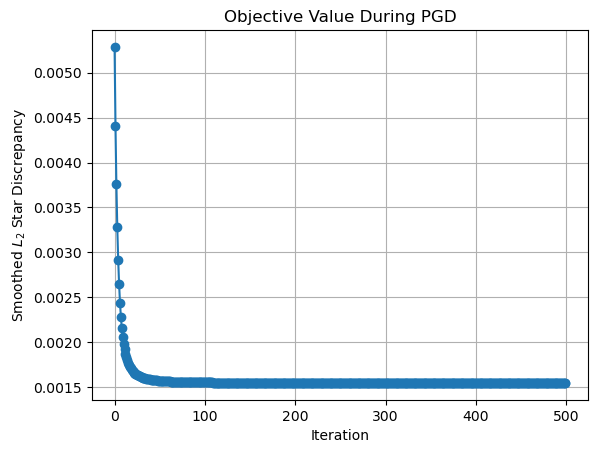

Initial L2 star discrepancy: 0.0064923361820569125
Final discrepancy value: 0.0015466874488754695
Optimized Points:
 [[0.09146638 0.09145693]
 [0.18050864 0.65306394]
 [0.30426536 0.31856834]
 [0.37189179 0.86957479]
 [0.45988645 0.49745452]
 [0.59639467 0.1870871 ]
 [0.68466681 0.76218066]
 [0.78993519 0.38937254]
 [0.83077631 0.98003505]
 [0.91676311 0.57043536]]


In [21]:
# === Generate Halton points ===
init_points = fibonacci_points(10)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

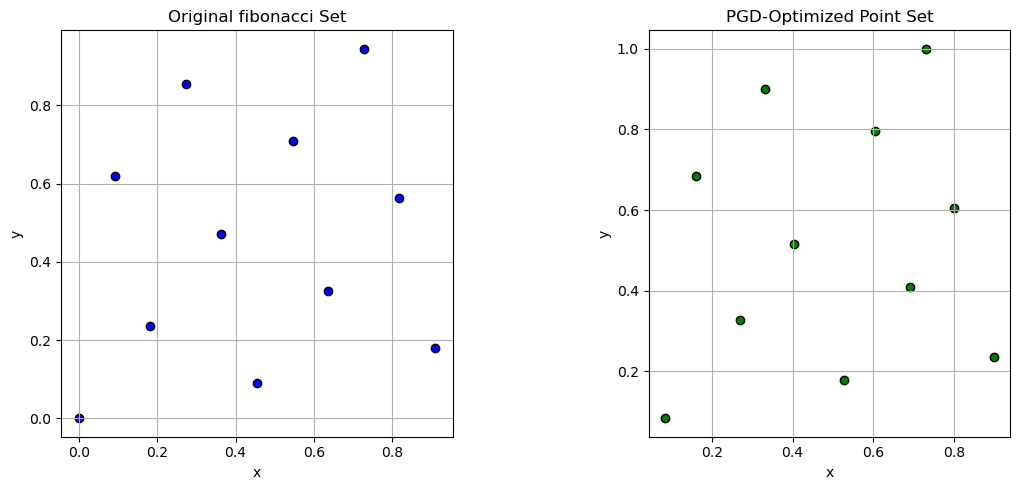

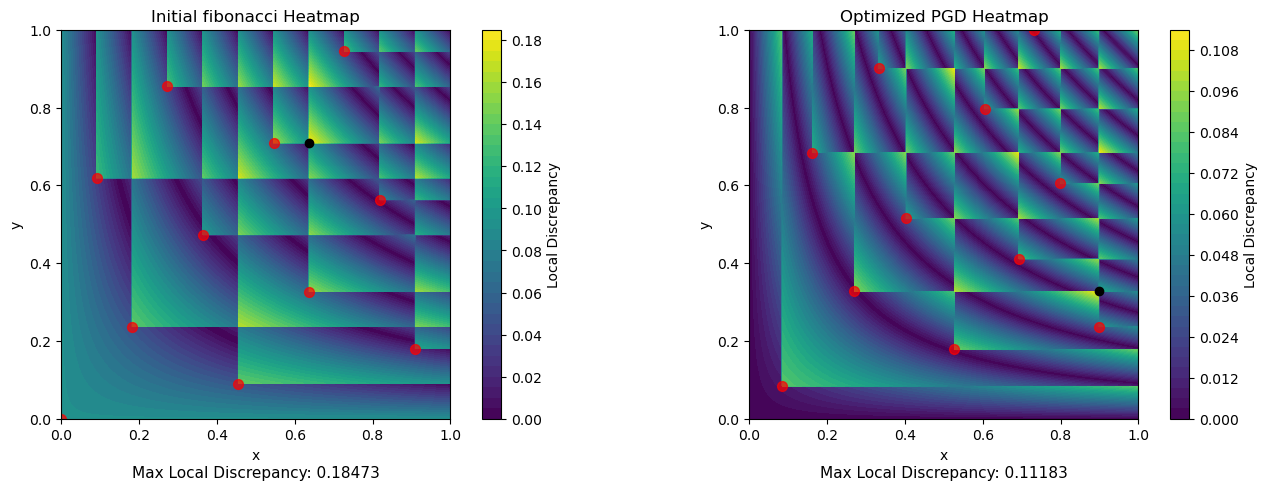

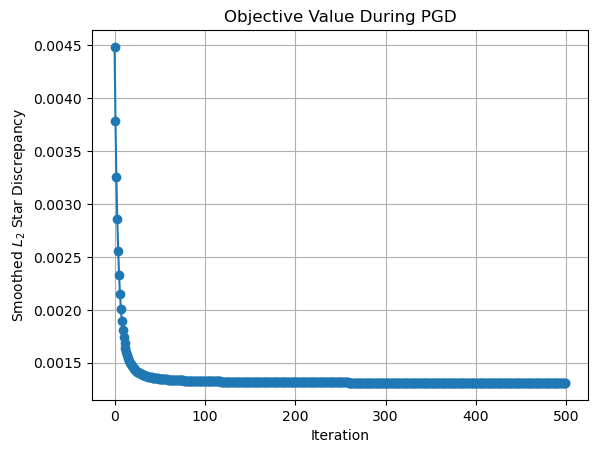

Initial L2 star discrepancy: 0.005429892970637673
Final discrepancy value: 0.0013095144322925606
Optimized Points:
 [[0.08381915 0.08378991]
 [0.16101933 0.6840911 ]
 [0.26947135 0.32700612]
 [0.33243979 0.90071348]
 [0.40215603 0.5147976 ]
 [0.52656419 0.17806838]
 [0.6047764  0.79646149]
 [0.69200092 0.41005348]
 [0.73092297 0.99999999]
 [0.7997118  0.60468638]
 [0.8987711  0.23627061]]


In [23]:
# === Generate Halton points ===
init_points = fibonacci_points(11)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

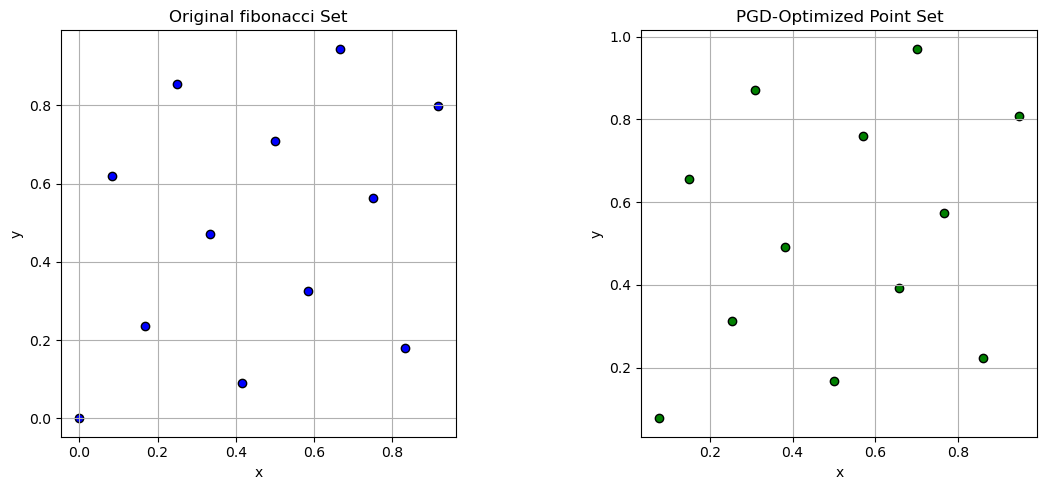

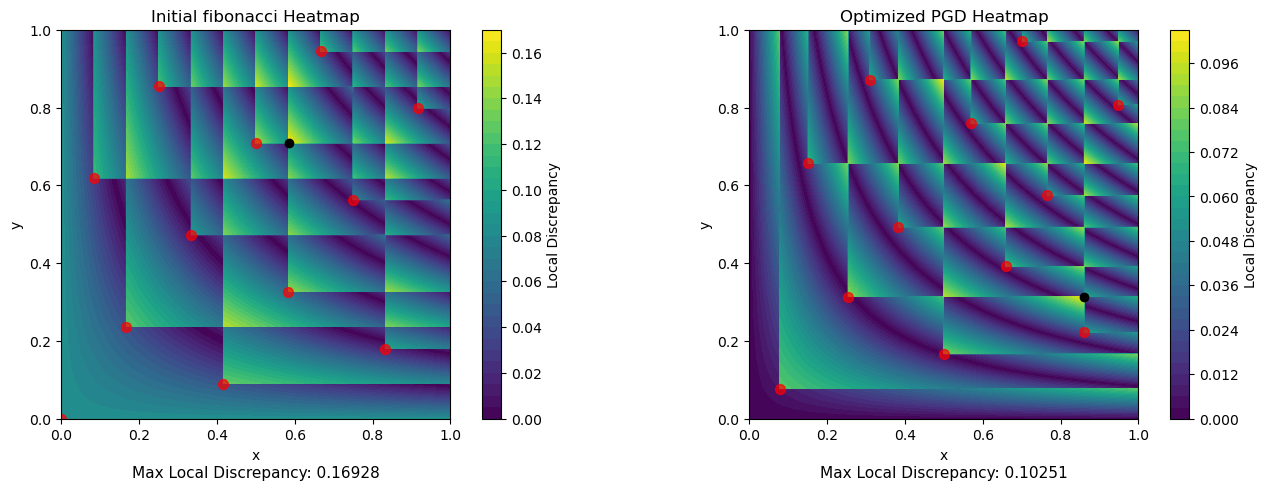

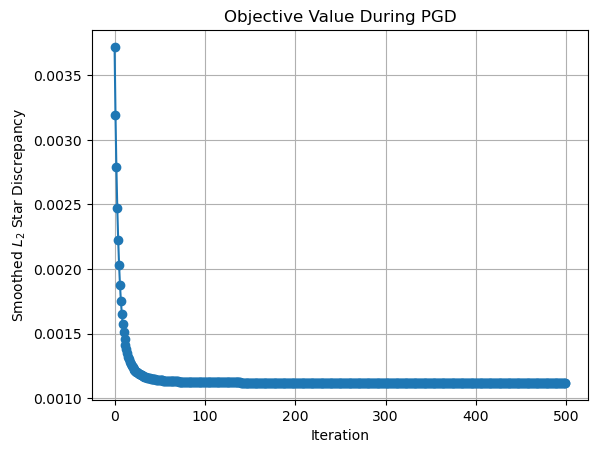

Initial L2 star discrepancy: 0.004401737065337447
Final discrepancy value: 0.0011182561239180405
Optimized Points:
 [[0.07736785 0.07733045]
 [0.15003031 0.65686257]
 [0.25344781 0.31316105]
 [0.30944695 0.87150256]
 [0.38218506 0.49254828]
 [0.49942934 0.16629211]
 [0.56995945 0.75982425]
 [0.65840558 0.39190013]
 [0.70168938 0.97084738]
 [0.76535259 0.57423386]
 [0.86043243 0.22197253]
 [0.94853919 0.80756013]]


In [25]:
# === Generate Halton points ===
init_points = fibonacci_points(12)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

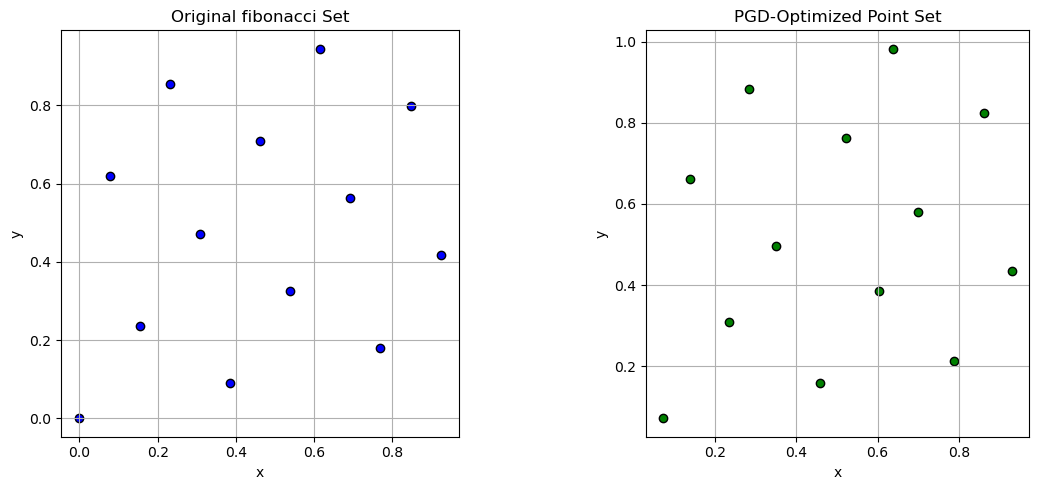

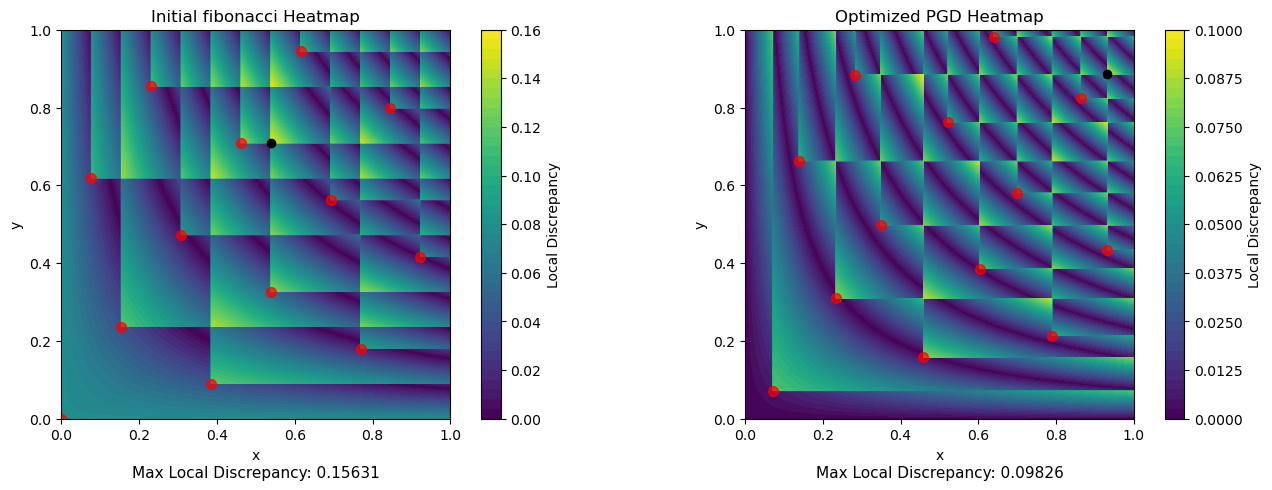

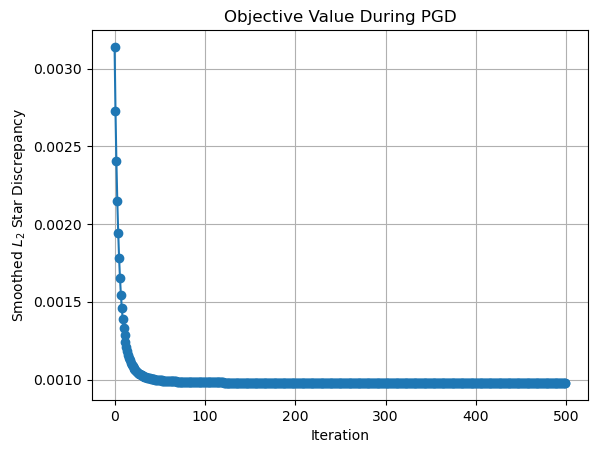

Initial L2 star discrepancy: 0.0036601228877709002
Final discrepancy value: 0.00097816365612996
Optimized Points:
 [[0.07186181 0.07180744]
 [0.13800335 0.66247498]
 [0.2334369  0.30913414]
 [0.28359585 0.88424715]
 [0.34886712 0.49765247]
 [0.45877079 0.15787598]
 [0.52139566 0.76157931]
 [0.60379549 0.38595896]
 [0.63888736 0.98258251]
 [0.69904119 0.58088958]
 [0.78943905 0.21346125]
 [0.86331791 0.82324685]
 [0.93146045 0.43405652]]


In [27]:
# === Generate Halton points ===
init_points = fibonacci_points(13)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

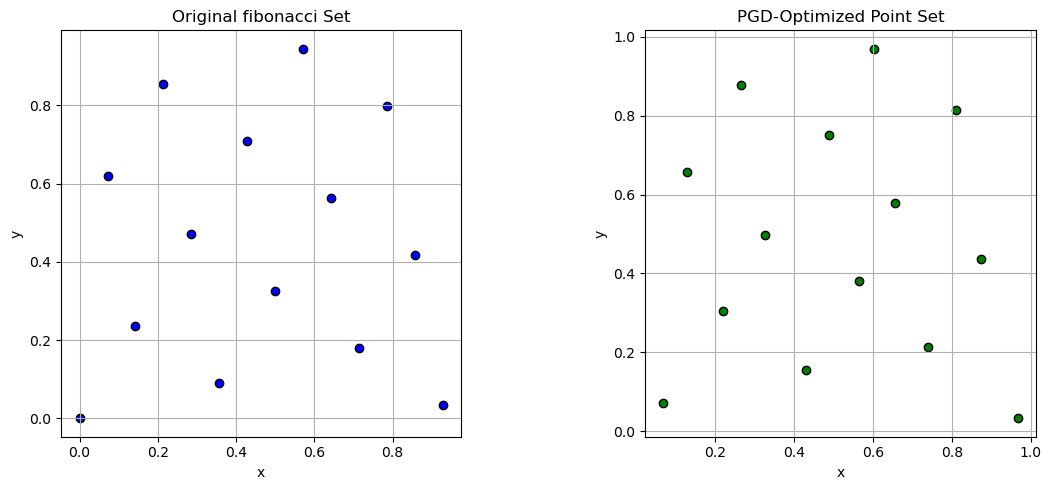

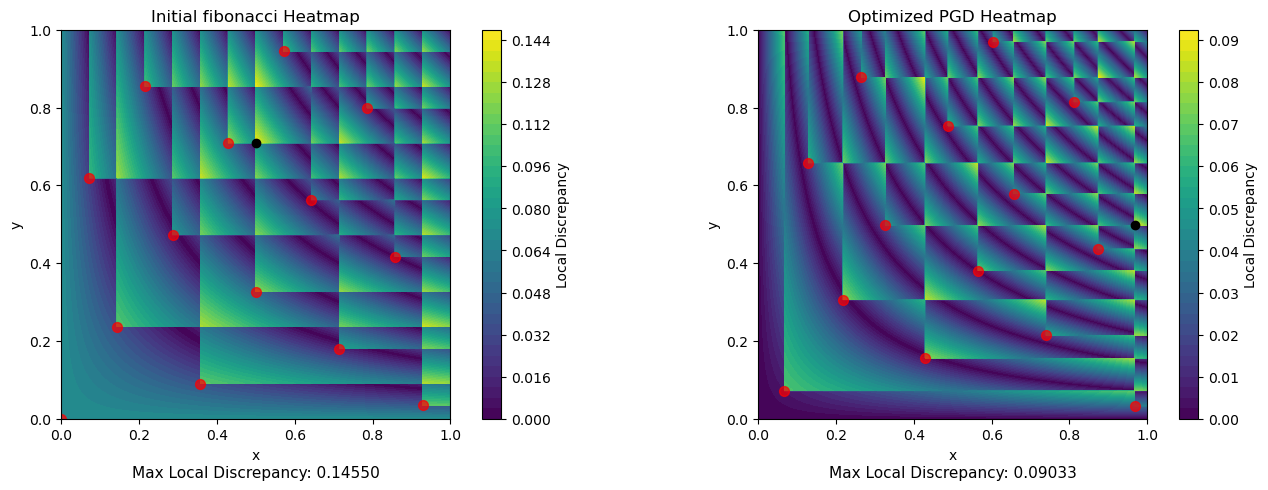

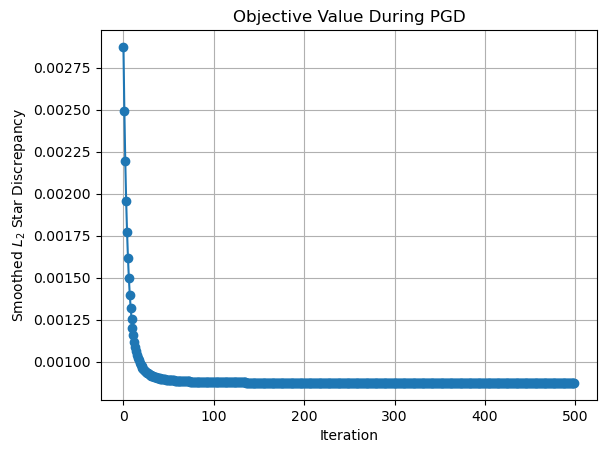

Initial L2 star discrepancy: 0.0033526963822718414
Final discrepancy value: 0.0008738988943369497
Optimized Points:
 [[0.06681686 0.07159619]
 [0.12849427 0.65783737]
 [0.21787685 0.30524659]
 [0.26424985 0.8776017 ]
 [0.32610108 0.49671761]
 [0.42858023 0.15536257]
 [0.48741754 0.75200207]
 [0.56476459 0.38019165]
 [0.6031136  0.96973335]
 [0.65639901 0.57870637]
 [0.73995383 0.21432393]
 [0.81104234 0.81407607]
 [0.87306814 0.43691021]
 [0.96771232 0.03293225]]


In [29]:
# === Generate Halton points ===
init_points = fibonacci_points(14)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

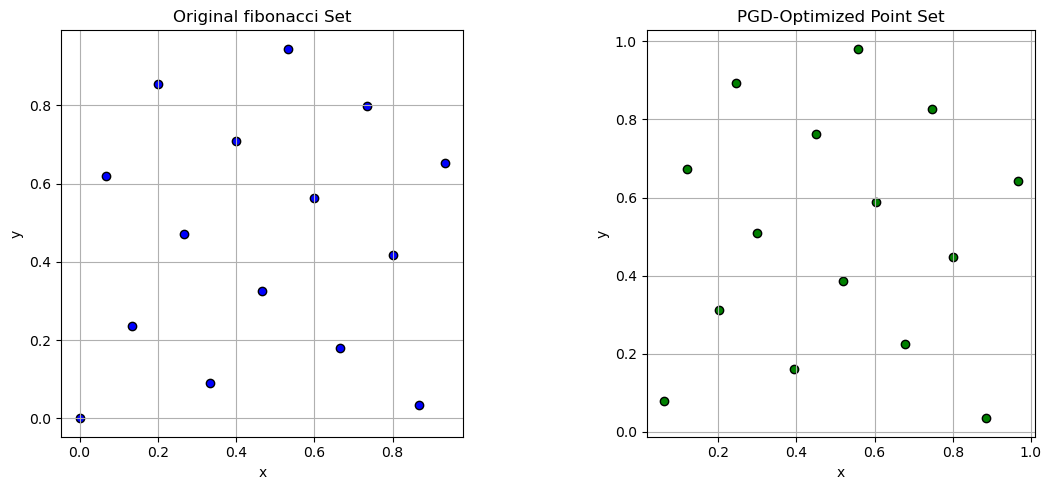

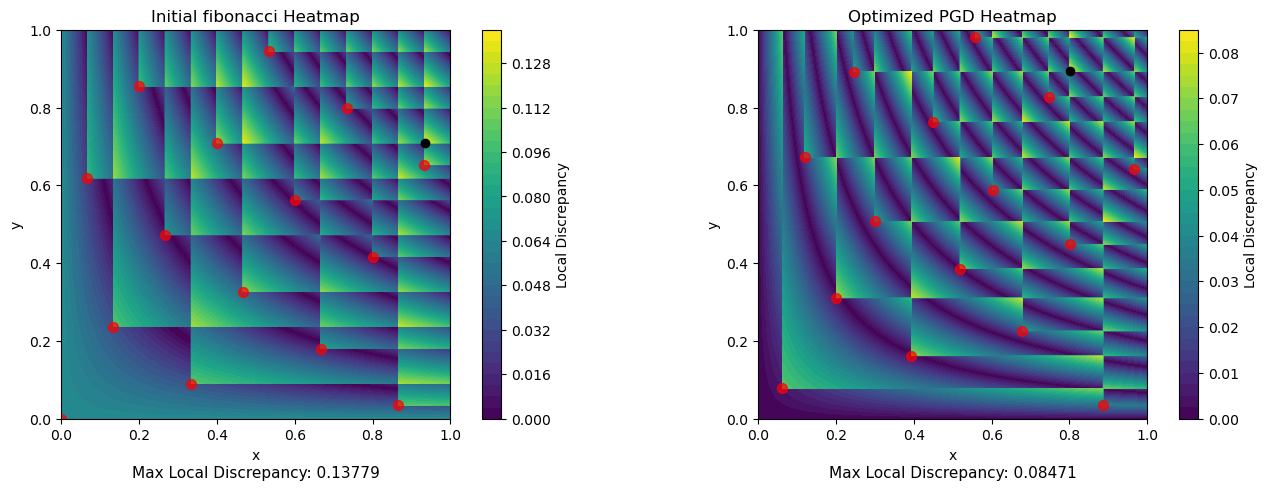

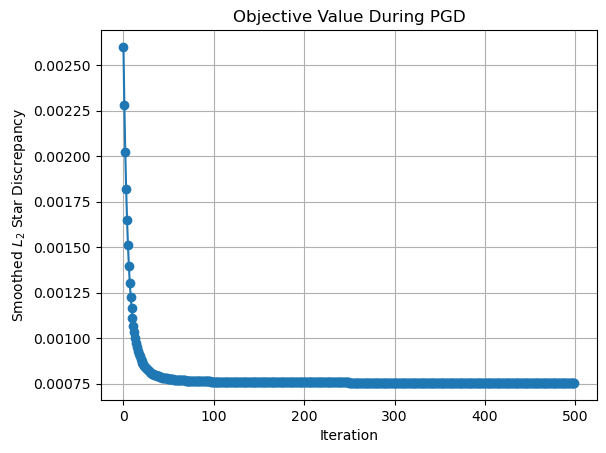

Initial L2 star discrepancy: 0.0029959428805683697
Final discrepancy value: 0.0007546401074602777
Optimized Points:
 [[0.06207398 0.07785355]
 [0.11893561 0.67171729]
 [0.20091177 0.3108511 ]
 [0.24479067 0.89229513]
 [0.29898568 0.5078816 ]
 [0.39353235 0.1610998 ]
 [0.4494958  0.76308593]
 [0.51896264 0.3857972 ]
 [0.55811447 0.98065299]
 [0.60253    0.58918074]
 [0.67887709 0.22565543]
 [0.74649474 0.82725036]
 [0.80098404 0.44789159]
 [0.88624352 0.03492546]
 [0.96667946 0.64217848]]


In [31]:
# === Generate Halton points ===
init_points = fibonacci_points(15)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

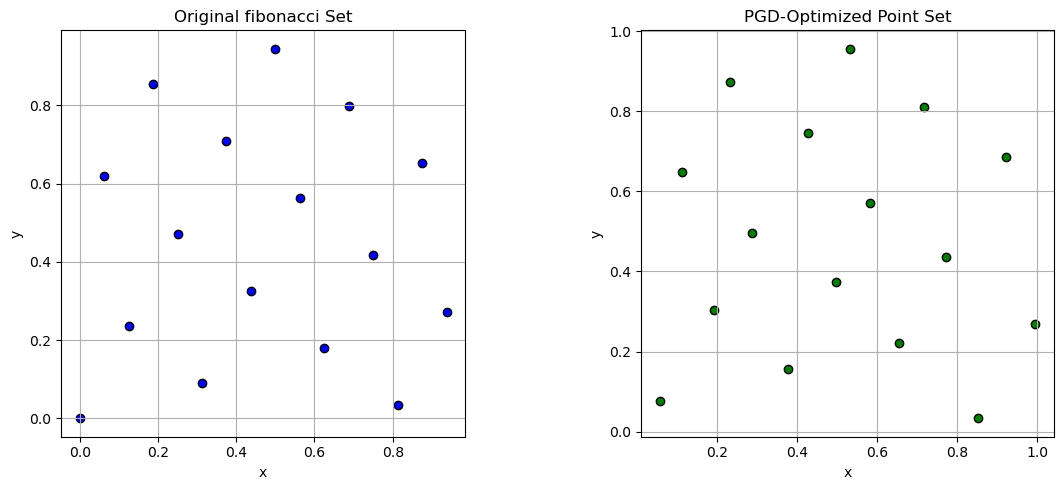

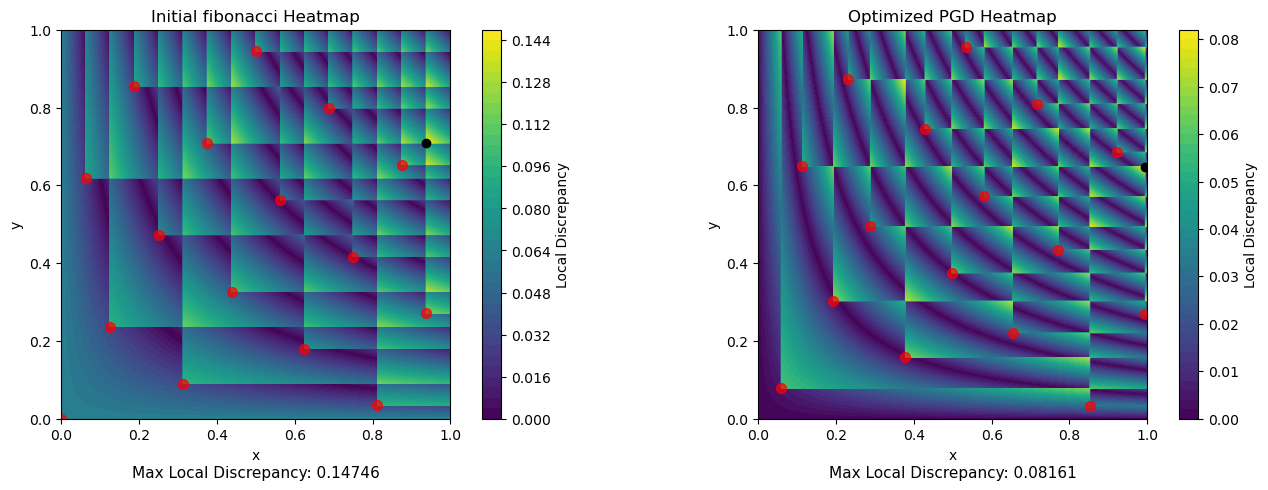

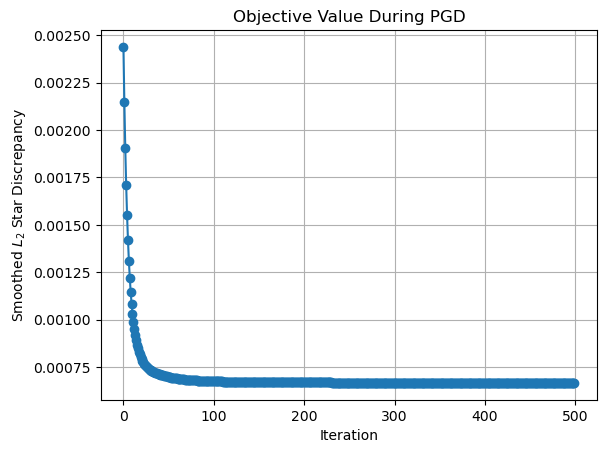

Initial L2 star discrepancy: 0.0027980002032659823
Final discrepancy value: 0.0006666085087248808
Optimized Points:
 [[0.05827687 0.07755939]
 [0.11304473 0.64844068]
 [0.19216654 0.30281116]
 [0.23157283 0.87210109]
 [0.28774106 0.49492382]
 [0.3772401  0.15750866]
 [0.42840626 0.74540239]
 [0.49781221 0.37473761]
 [0.53283334 0.95561393]
 [0.58090187 0.57187028]
 [0.65383587 0.22066272]
 [0.71654566 0.80932523]
 [0.77121715 0.43486632]
 [0.85217395 0.03372468]
 [0.92238626 0.68500463]
 [0.9948404  0.26984797]]


In [33]:
# === Generate Halton points ===
init_points = fibonacci_points(16)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

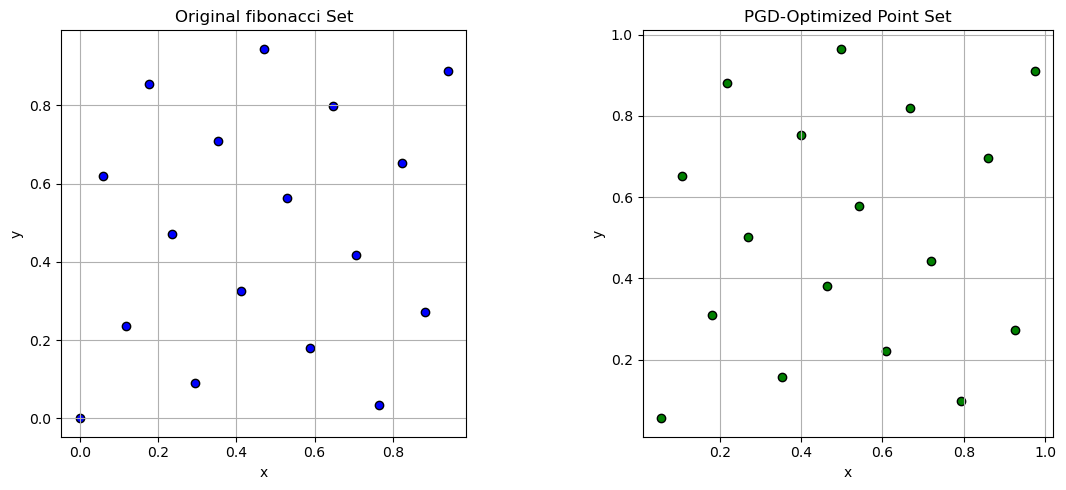

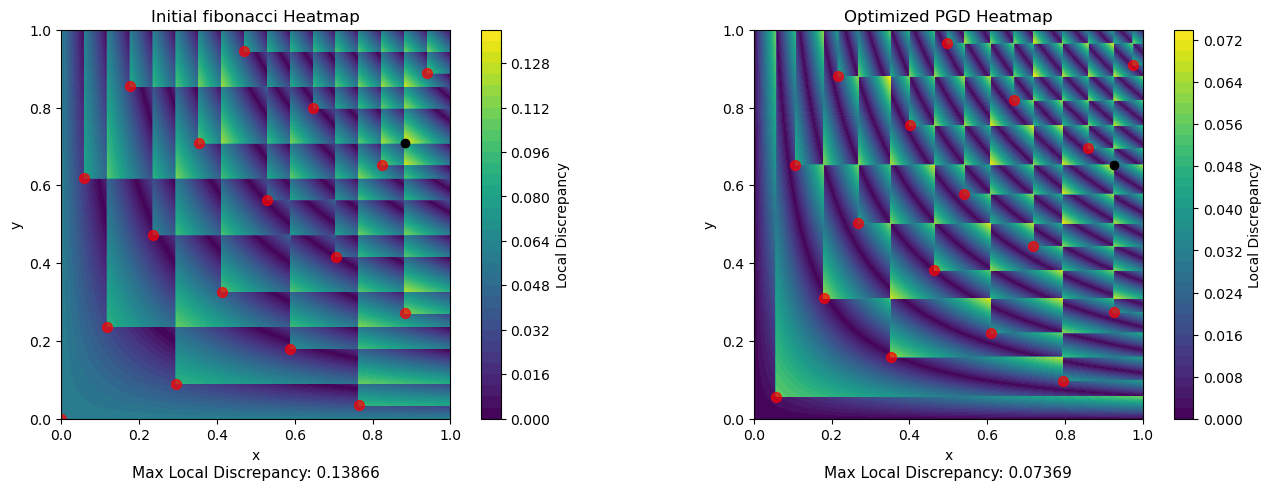

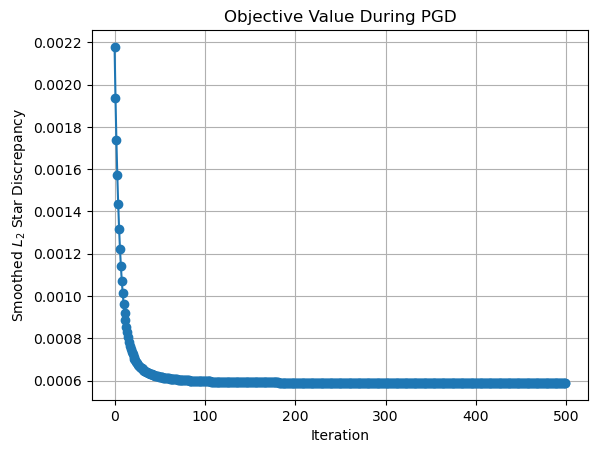

Initial L2 star discrepancy: 0.0024684603747565648
Final discrepancy value: 0.0005889327782032799
Optimized Points:
 [[0.05605362 0.05607081]
 [0.10609888 0.65266768]
 [0.17986774 0.30976103]
 [0.21694723 0.88068938]
 [0.26868209 0.50238617]
 [0.35186653 0.15801844]
 [0.40028565 0.75398964]
 [0.46426976 0.38151385]
 [0.49725458 0.9650837 ]
 [0.54146231 0.57788365]
 [0.6084248  0.22079066]
 [0.66822882 0.81821312]
 [0.71830287 0.44399124]
 [0.79381938 0.09731642]
 [0.85993628 0.69552726]
 [0.92567827 0.27336389]
 [0.97451152 0.90949196]]


In [35]:
# === Generate Halton points ===
init_points = fibonacci_points(17)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

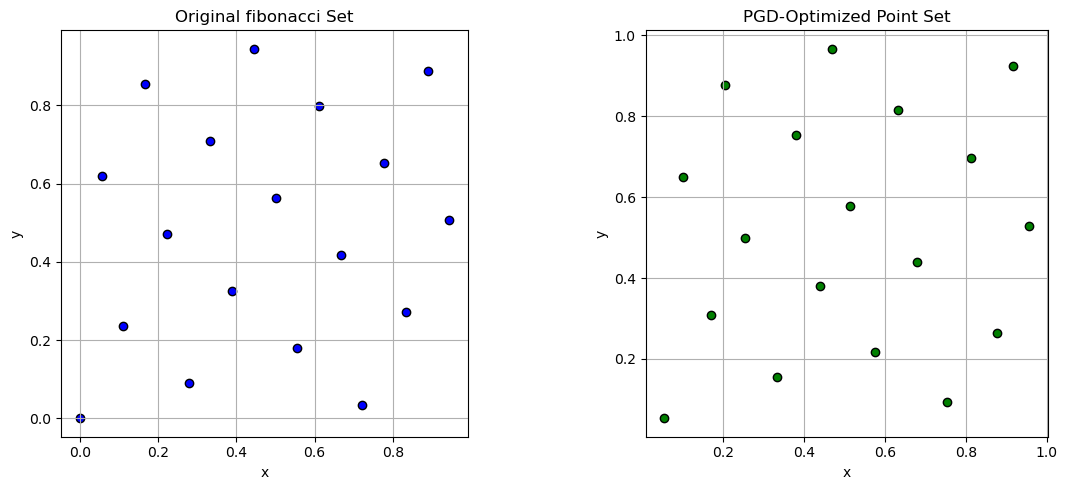

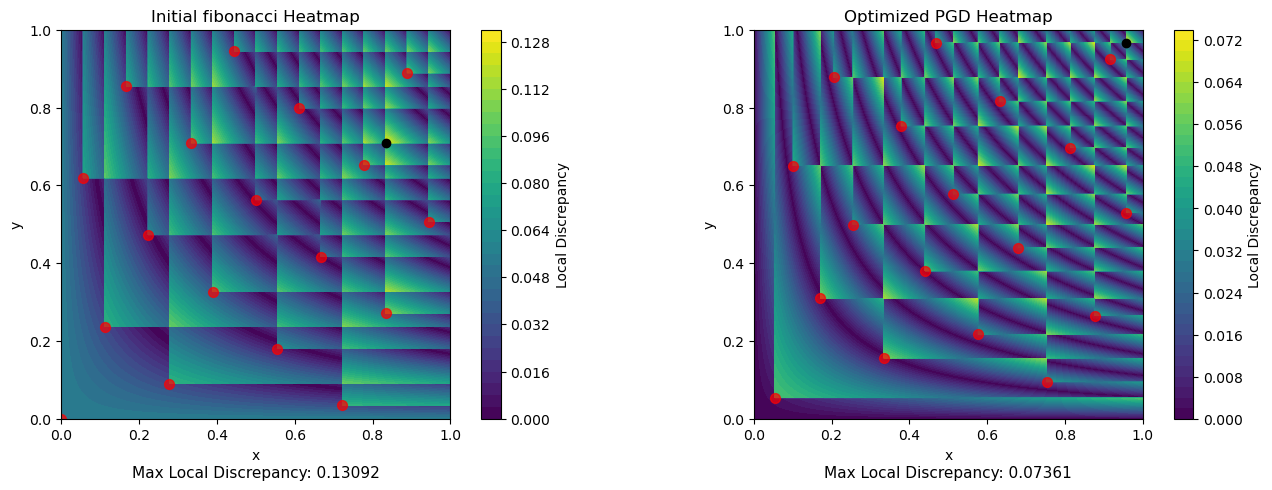

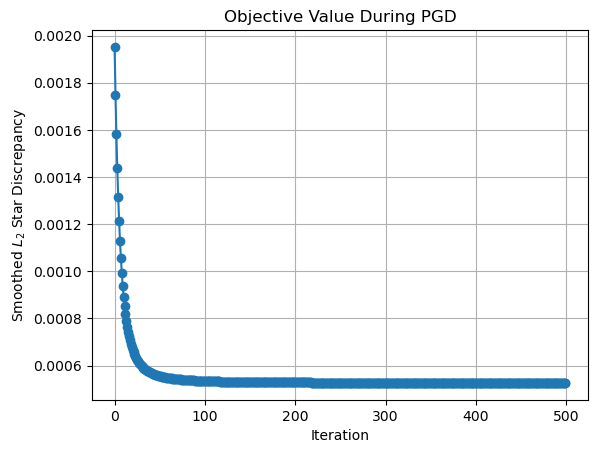

Initial L2 star discrepancy: 0.0021927380371713767
Final discrepancy value: 0.0005265506583840007
Optimized Points:
 [[0.05316214 0.05318198]
 [0.10034378 0.65019375]
 [0.17025642 0.30932393]
 [0.20515789 0.8778918 ]
 [0.25465867 0.49918303]
 [0.33353229 0.15575889]
 [0.3788708  0.75289177]
 [0.4399449  0.37910693]
 [0.46773584 0.96696412]
 [0.51220114 0.57783959]
 [0.57601974 0.21691924]
 [0.63168332 0.81607814]
 [0.67988746 0.43967265]
 [0.75247969 0.09419249]
 [0.81314245 0.69611391]
 [0.87674322 0.26524227]
 [0.9163967  0.9239813 ]
 [0.95713808 0.52974139]]


In [37]:
# === Generate Halton points ===
init_points = fibonacci_points(18)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

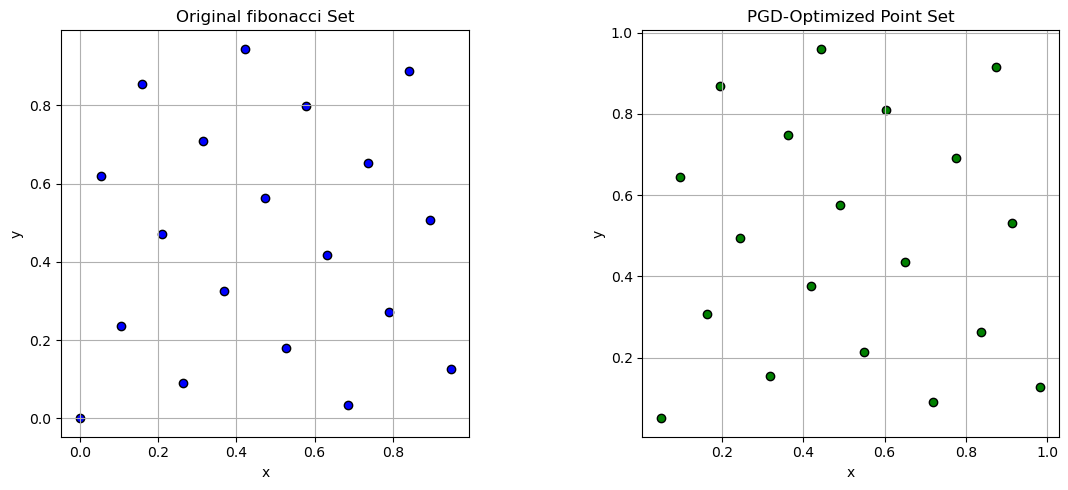

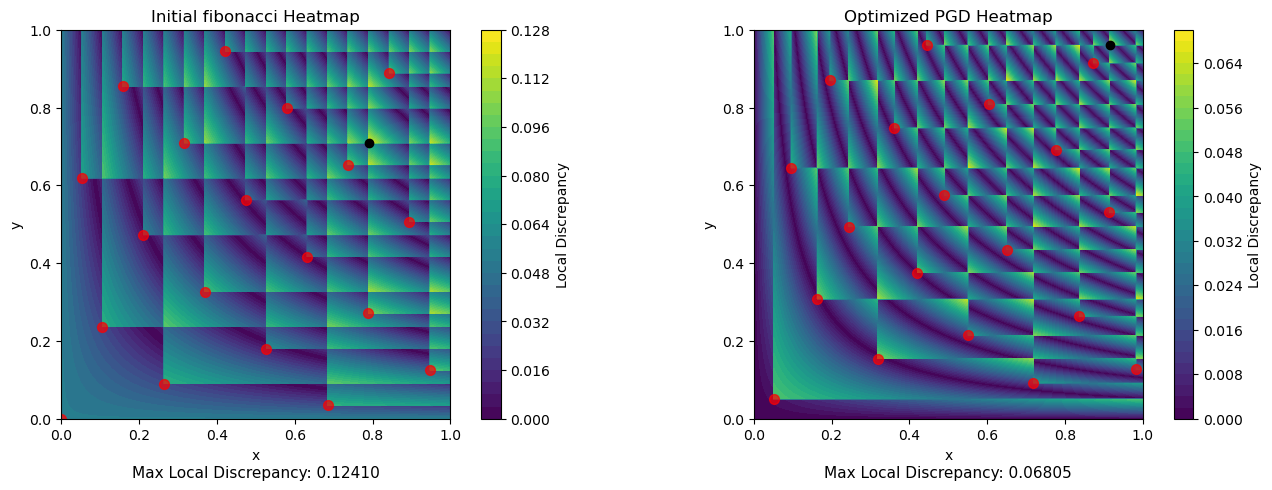

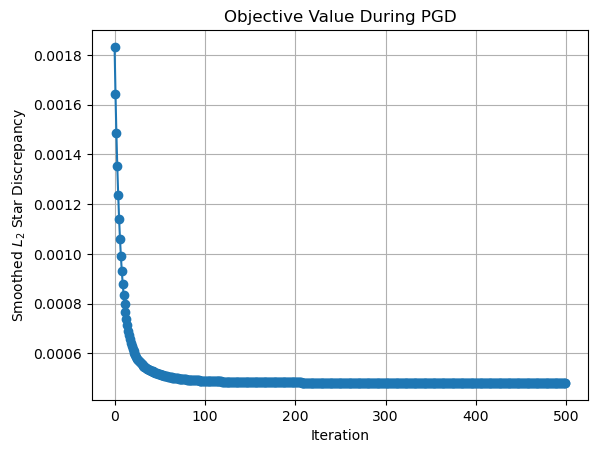

Initial L2 star discrepancy: 0.002055393806310535
Final discrepancy value: 0.00048167597627213343
Optimized Points:
 [[0.05056737 0.05058141]
 [0.09535626 0.64472068]
 [0.16205395 0.30786927]
 [0.19511214 0.86973093]
 [0.2432708  0.49372759]
 [0.31824877 0.1546015 ]
 [0.36124115 0.7471279 ]
 [0.42004002 0.37559386]
 [0.44447864 0.96013593]
 [0.4893116  0.57477398]
 [0.5500467  0.21445077]
 [0.60324623 0.8086462 ]
 [0.64951673 0.43447436]
 [0.71878806 0.0911077 ]
 [0.77607257 0.69162697]
 [0.83704156 0.26322239]
 [0.87318068 0.91469587]
 [0.9141141  0.53082618]
 [0.98268593 0.12651969]]


In [39]:
# === Generate Halton points ===
init_points = fibonacci_points(19)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)

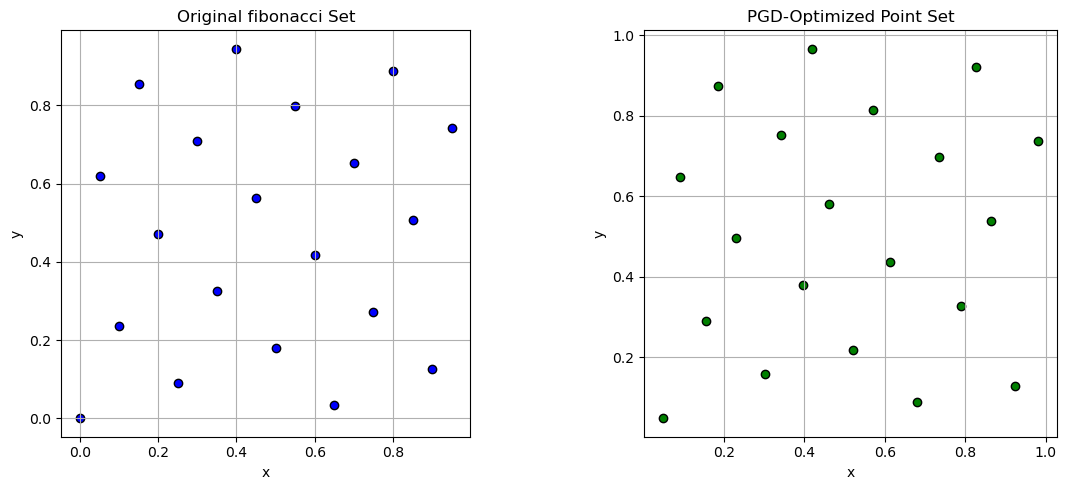

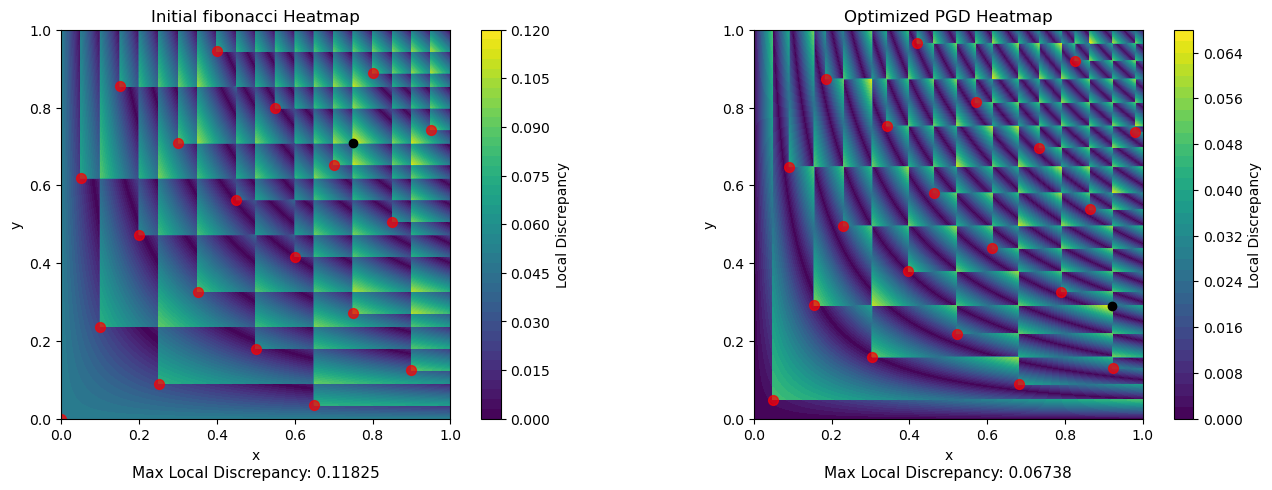

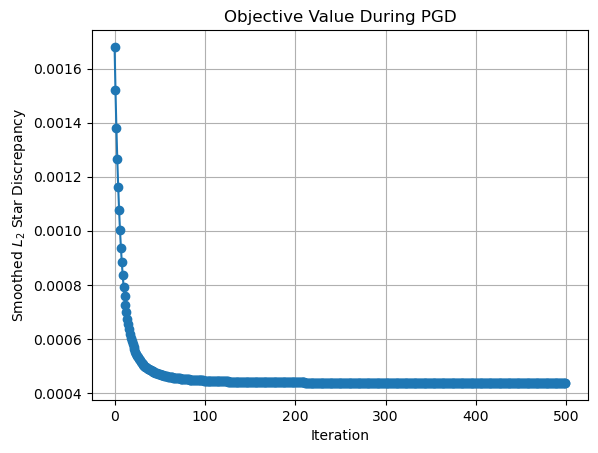

Initial L2 star discrepancy: 0.001869464413952665
Final discrepancy value: 0.00043696481416147237
Optimized Points:
 [[0.0482252  0.04822809]
 [0.09041413 0.64736631]
 [0.15482386 0.29099978]
 [0.1848211  0.87331408]
 [0.23026984 0.49543343]
 [0.30316516 0.15850785]
 [0.34192882 0.7527244 ]
 [0.39736808 0.3789181 ]
 [0.41951728 0.96588232]
 [0.46224549 0.58002175]
 [0.52145063 0.21830675]
 [0.57038743 0.81392973]
 [0.61346169 0.437537  ]
 [0.68036672 0.08863321]
 [0.73342435 0.69624084]
 [0.7900549  0.3262965 ]
 [0.82576494 0.92022247]
 [0.86318298 0.5383553 ]
 [0.92288229 0.12915336]
 [0.98035315 0.73636974]]


In [41]:
# === Generate Halton points ===
init_points = fibonacci_points(20)

# === Optimize ===
initial_discrepancy_value = L2(init_points)
optimized_points, objective_history = PGD_L2(init_points)

# === Side-by-side: point sets ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
axs[0].set_title("Original fibonacci Set")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].grid(True)
axs[0].set_aspect('equal')

axs[1].scatter(optimized_points[:, 0], optimized_points[:, 1], c='green', edgecolor='black')
axs[1].set_title("PGD-Optimized Point Set")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].grid(True)
axs[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# === Side-by-side: heatmaps ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap for initial set
_, max_init = heatmap_from_array(init_points, ax=axs[0])
axs[0].set_title("Initial fibonacci Heatmap")
axs[0].text(0.5, -0.15, f"Max Local Discrepancy: {max_init:.5f}",
            transform=axs[0].transAxes, ha='center', fontsize=11)

# Heatmap for optimized set
_, max_opt = heatmap_from_array(optimized_points, ax=axs[1])
axs[1].set_title("Optimized PGD Heatmap")
axs[1].text(0.5, -0.15, f"Max Local Discrepancy: {max_opt:.5f}",
            transform=axs[1].transAxes, ha='center', fontsize=11)

plt.tight_layout()
plt.show()

# === Objective plot ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output ===
print("Initial L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Optimized Points:\n", optimized_points)